In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, LeakyReLU, BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Input
from tensorflow.keras import backend as K

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


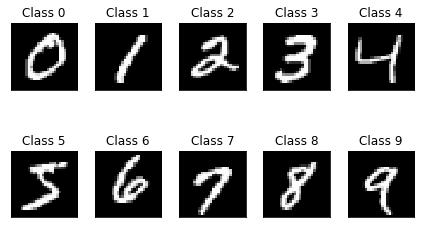

In [0]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()


In [0]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


In [0]:
def generator():
  model = Sequential()
  
  model.add(Dense(7*7*256, use_bias=False, input_shape = (100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  
  model.add(Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256)
  
  model.add(Conv2DTranspose(128, (5,5), strides = (1, 1), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 7, 7, 128)
  
  model.add(Conv2DTranspose(64, (5,5), strides = (2, 2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 14, 14, 64)
  
  model.add(Conv2DTranspose(1, (5,5), strides = (2, 2), padding='same', activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  
  print(model.summary())
  
  return model

In [0]:
def discriminator():
  model = Sequential()

  model.add(Conv2D(32, (5,5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (5,5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  
  print(model.summary())

  return model

            

In [0]:
gen_model = generator()
dis_model = discriminator()
dis_model.compile(loss = 'binary_crossentropy', optimizer = Optimizer.Adam(lr=0.0003), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_v1 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 7, 7, 128)         512       
_________________________________________________________________
leak

In [0]:
dis_model.trainable = False

noise = Input(shape=(100,))
gen_output = gen_model(noise)
decision = dis_model(gen_output)
gan = Model(inputs=noise, outputs=decision) 

In [0]:
gan.compile(optimizer=Optimizer.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

Instructions for updating:
Use tf.cast instead.
epoch = 1/100, d_loss=0.168, g_loss=9.010                                                                                                     


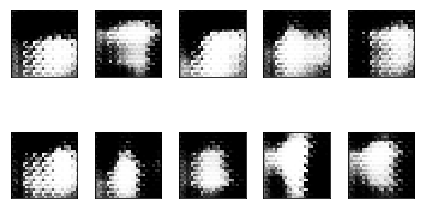

epoch = 2/100, d_loss=0.211, g_loss=5.229                                                                                                     
epoch = 3/100, d_loss=0.503, g_loss=2.254                                                                                                     
epoch = 4/100, d_loss=0.482, g_loss=2.111                                                                                                     
epoch = 5/100, d_loss=0.555, g_loss=1.594                                                                                                     
epoch = 6/100, d_loss=0.524, g_loss=1.640                                                                                                     
epoch = 7/100, d_loss=0.636, g_loss=1.410                                                                                                     
epoch = 8/100, d_loss=0.569, g_loss=1.194                                                                                                     

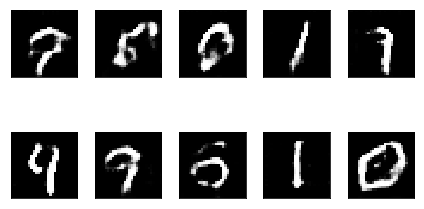

epoch = 12/100, d_loss=0.641, g_loss=1.241                                                                                                     
epoch = 13/100, d_loss=0.616, g_loss=1.405                                                                                                     
epoch = 14/100, d_loss=0.624, g_loss=1.308                                                                                                     
epoch = 15/100, d_loss=0.556, g_loss=1.527                                                                                                     
epoch = 16/100, d_loss=0.583, g_loss=1.248                                                                                                     
epoch = 17/100, d_loss=0.628, g_loss=1.176                                                                                                     
epoch = 18/100, d_loss=0.603, g_loss=1.247                                                                                              

In [0]:
epochs = 100

smooth = 0.1
batch_size = 64

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

dis_loss = []
gan_loss = []

for e in range(epochs+1):
  for i in range(len(X_train) // batch_size):
    dis_model.trainable = True

    # Real samples given to discriminator
    X_batch = X_train[i*batch_size:(i+1)*batch_size]
    d_loss_real = dis_model.train_on_batch(x=X_batch, y=real * (1 - smooth))

    #Fake images are generated by generator and are fed again to discriminator
    z = np.random.normal(loc=0, scale=1, size=(batch_size, 100))
    X_fake = gen_model.predict_on_batch(z)
    d_loss_fake = dis_model.train_on_batch(x=X_fake, y=fake)

    #Calculating overall loss
    d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

    # Train Generator weights
    dis_model.trainable = False
    d_g_loss_batch = gan.train_on_batch(x=z, y=real)


    """print(
          'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
          100*' ',
          end='\r'
          )"""

  dis_loss.append(d_loss_batch)
  gan_loss.append(d_g_loss_batch[0])
  print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, dis_loss[-1], gan_loss[-1]), 100*' ')

  if e % 10 == 0:
    samples = 10
    x_fake = gen_model.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

    for k in range(samples):
      plt.subplot(2, 5, k+1)
      plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
      plt.xticks([])
      plt.yticks([])

    plt.tight_layout()
    plt.show()
  